# Stock ML Project: Next-day Return & Direction

## Goal
Build a **leakage-safe** machine learning pipeline to predict:

- **Next-day return** (regression)
- **Next-day direction** up/down (classification)

using only information available up to time \(t\).

> This notebook uses your existing loaded data and turns it into a complete, runnable mini-project (features → split → baselines → ML → evaluation → simple backtest).

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd

In [4]:
# load data (use your CSV; no data is created here)
# If you already have df loaded, you can skip/re-run safely.

from pathlib import Path

# 1) Put your CSV path here (Colab path won't work locally)
df = pd.read_csv('/content/drive/MyDrive/Stock_price_prediction/stock_data.csv')

# Clean/standardize
# Your file uses an "Unnamed: 0" column that appears to be the date.
if "Unnamed: 0" in df.columns and "Date" not in df.columns:
    df = df.rename(columns={"Unnamed: 0": "Date"})

if "Date" in df.columns:
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
    df = df.dropna(subset=["Date"]).set_index("Date").sort_index()

# Keep only numeric price columns
df = df.apply(pd.to_numeric, errors="coerce")

df.head()

,Stock_1,Stock_2,Stock_3,Stock_4,Stock_5
Date,,,,,
2020-01-01,101.764052,100.160928,99.494642,99.909756,101.761266
2020-01-02,102.171269,99.969968,98.682973,100.640755,102.528643
2020-01-03,103.171258,99.575237,98.182139,100.574847,101.887811
2020-01-04,105.483215,99.308641,97.149381,100.925017,101.490049
2020-01-05,107.453175,98.188428,99.575396,101.594411,101.604283


In [5]:
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    mean_absolute_error,
    mean_squared_error,
    precision_score,
    recall_score,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

try:
    from IPython.display import display
except Exception:
    display = print


def make_features_from_close(close: pd.Series) -> pd.DataFrame:
    """Leakage-safe features using only data available up to time t."""
    close = close.astype(float)
    ret_1d = close.pct_change()

    X = pd.DataFrame(index=close.index)

    # lagged returns
    for lag in [1, 2, 3, 5, 10, 20]:
        X[f"ret_lag_{lag}"] = ret_1d.shift(lag)

    # rolling stats of returns
    for w in [5, 10, 20]:
        X[f"ret_mean_{w}"] = ret_1d.rolling(w).mean()
        X[f"ret_std_{w}"] = ret_1d.rolling(w).std()

    # momentum (price change over window)
    for w in [5, 10, 20]:
        X[f"mom_{w}"] = close.pct_change(w)

    # RSI(14)
    delta = close.diff()
    up = delta.clip(lower=0)
    down = (-delta).clip(lower=0)
    roll = 14
    rs = up.rolling(roll).mean() / (down.rolling(roll).mean() + 1e-12)
    X["rsi_14"] = 100 - (100 / (1 + rs))

    # MACD (12, 26, 9)
    ema12 = close.ewm(span=12, adjust=False).mean()
    ema26 = close.ewm(span=26, adjust=False).mean()
    macd = ema12 - ema26
    macd_signal = macd.ewm(span=9, adjust=False).mean()
    X["macd"] = macd
    X["macd_signal"] = macd_signal
    X["macd_hist"] = macd - macd_signal

    # Bollinger z-score (20)
    ma20 = close.rolling(20).mean()
    std20 = close.rolling(20).std()
    X["bb_z_20"] = (close - ma20) / (std20 + 1e-12)

    return X


def make_targets_from_close(close: pd.Series) -> tuple[pd.Series, pd.Series]:
    """Targets at time t: next-day return and direction."""
    y_return = close.pct_change().shift(-1)  # return from t -> t+1
    y_dir = (y_return > 0).astype(int)
    return y_return, y_dir


def time_split(df_xy: pd.DataFrame, train_frac=0.70, val_frac=0.15):
    """Chronological train/val/test split."""
    n = len(df_xy)
    train_end = int(n * train_frac)
    val_end = int(n * (train_frac + val_frac))
    train = df_xy.iloc[:train_end]
    val = df_xy.iloc[train_end:val_end]
    test = df_xy.iloc[val_end:]
    return train, val, test


def backtest_long_flat(pred_dir: pd.Series, actual_next_return: pd.Series, cost_bps: float = 5.0):
    """Simple long/flat backtest using predicted direction.

    - pred_dir: 1=long, 0=flat
    - actual_next_return: return from t -> t+1
    - cost_bps: per trade cost in basis points (5 bps = 0.05%)
    """
    signal = pred_dir.astype(float).reindex(actual_next_return.index)
    signal = signal.fillna(0.0)

    # cost when switching position
    trades = signal.diff().abs().fillna(signal.abs())
    cost = (cost_bps / 10000.0) * trades

    strat_ret = signal * actual_next_return.fillna(0.0) - cost

    equity = (1.0 + strat_ret).cumprod()
    bh_equity = (1.0 + actual_next_return.fillna(0.0)).cumprod()

    daily = strat_ret.dropna()
    sharpe = np.nan
    if daily.std(ddof=0) > 0:
        sharpe = (daily.mean() / daily.std(ddof=0)) * np.sqrt(252)

    dd = equity / equity.cummax() - 1.0

    return {
        "equity": equity,
        "buy_hold_equity": bh_equity,
        "cumulative_return": float(equity.iloc[-1] - 1.0) if len(equity) else np.nan,
        "sharpe": float(sharpe) if sharpe == sharpe else np.nan,
        "max_drawdown": float(dd.min()) if len(dd) else np.nan,
        "win_rate": float((daily > 0).mean()) if len(daily) else np.nan,
    }


def fit_and_evaluate_one_stock(close: pd.Series, stock_name: str):
    # Build features/targets
    X = make_features_from_close(close)
    y_ret, y_dir = make_targets_from_close(close)

    data = X.copy()
    data["y_return"] = y_ret
    data["y_dir"] = y_dir
    data = data.dropna()

    if len(data) < 200:
        raise ValueError(f"Not enough rows after feature engineering for {stock_name}: {len(data)}")

    train, val, test = time_split(data)

    feature_cols = [c for c in data.columns if c not in {"y_return", "y_dir"}]

    # Baselines
    # Regression baseline: predict 0 return
    yhat_ret_base = pd.Series(0.0, index=test.index)

    # Direction baseline: tomorrow direction = sign of today's return
    ret_today = close.pct_change().reindex(test.index)
    yhat_dir_base = (ret_today > 0).astype(int).fillna(0)

    # Models (simple + strong baselines)
    reg = Pipeline([
        ("scaler", StandardScaler()),
        ("model", Ridge(alpha=1.0)),
    ])

    clf = Pipeline([
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(max_iter=2000)),
    ])

    # Tiny hyperparameter search on validation (kept simple)
    best_alpha, best_rmse = None, np.inf
    for a in [0.1, 1.0, 10.0, 100.0]:
        reg.set_params(model__alpha=a)
        reg.fit(train[feature_cols], train["y_return"])
        pred = pd.Series(reg.predict(val[feature_cols]), index=val.index)
        rmse = np.sqrt(mean_squared_error(val["y_return"], pred))
        if rmse < best_rmse:
            best_rmse, best_alpha = rmse, a

    best_C, best_acc = None, -np.inf
    for C in [0.1, 1.0, 10.0]:
        clf.set_params(model__C=C)
        clf.fit(train[feature_cols], train["y_dir"])
        pred = pd.Series(clf.predict(val[feature_cols]), index=val.index)
        acc = accuracy_score(val["y_dir"], pred)
        if acc > best_acc:
            best_acc, best_C = acc, C

    # Refit on train+val using best params
    train_val = pd.concat([train, val])

    reg.set_params(model__alpha=best_alpha)
    reg.fit(train_val[feature_cols], train_val["y_return"])

    clf.set_params(model__C=best_C)
    clf.fit(train_val[feature_cols], train_val["y_dir"])

    # Predict on test
    yhat_ret = pd.Series(reg.predict(test[feature_cols]), index=test.index)
    yhat_dir = pd.Series(clf.predict(test[feature_cols]), index=test.index)

    # Metrics
    ret_mae = mean_absolute_error(test["y_return"], yhat_ret)
    ret_rmse = np.sqrt(mean_squared_error(test["y_return"], yhat_ret))

    dir_acc = accuracy_score(test["y_dir"], yhat_dir)
    dir_prec = precision_score(test["y_dir"], yhat_dir, zero_division=0)
    dir_rec = recall_score(test["y_dir"], yhat_dir, zero_division=0)
    dir_f1 = f1_score(test["y_dir"], yhat_dir, zero_division=0)

    dir_acc_base = accuracy_score(test["y_dir"], yhat_dir_base)
    ret_rmse_base = np.sqrt(mean_squared_error(test["y_return"], yhat_ret_base))

    # Backtest (use predicted direction; trade long/flat)
    bt = backtest_long_flat(yhat_dir, test["y_return"], cost_bps=5.0)
    bt_base = backtest_long_flat(yhat_dir_base, test["y_return"], cost_bps=5.0)

    summary = {
        "stock": stock_name,
        "rows_total": int(len(data)),
        "rows_test": int(len(test)),
        "ridge_alpha": float(best_alpha),
        "logreg_C": float(best_C),
        "return_mae": float(ret_mae),
        "return_rmse": float(ret_rmse),
        "return_rmse_baseline0": float(ret_rmse_base),
        "dir_accuracy": float(dir_acc),
        "dir_accuracy_baseline": float(dir_acc_base),
        "dir_precision": float(dir_prec),
        "dir_recall": float(dir_rec),
        "dir_f1": float(dir_f1),
        "strategy_cumret": float(bt["cumulative_return"]),
        "strategy_sharpe": float(bt["sharpe"]),
        "strategy_maxdd": float(bt["max_drawdown"]),
        "baseline_cumret": float(bt_base["cumulative_return"]),
        "buyhold_cumret": float(bt["buy_hold_equity"].iloc[-1] - 1.0),
    }

    artifacts = {
        "test": test,
        "pred_dir": yhat_dir,
        "pred_ret": yhat_ret,
        "bt": bt,
        "bt_base": bt_base,
    }

    return summary, artifacts

Predicted and Actual Next Day Prices for Stock_2:


,Real Price,Predicted Price
Date,,
2020-11-08,64.332863,63.291579
2020-11-09,64.587677,64.261904
2020-11-10,64.205704,64.425452
2020-11-11,64.927645,63.996967
2020-11-12,65.418106,64.760237


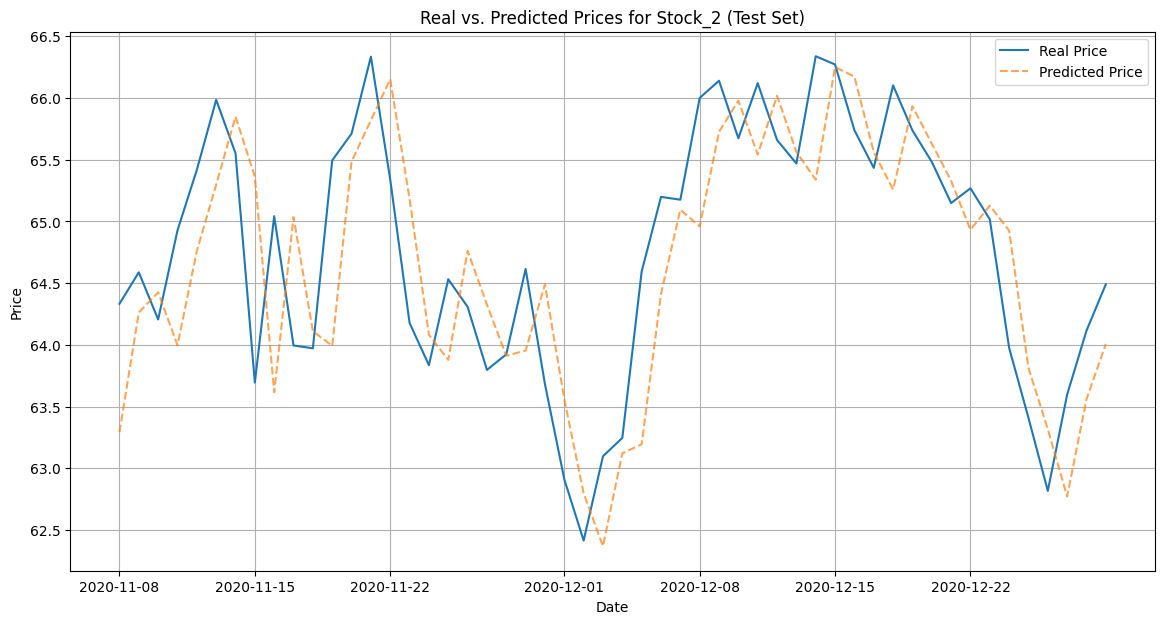

In [9]:
import matplotlib.pyplot as plt

# Get the best performing stock from the results_df
best_stock = results_df.iloc[0]["stock"]

# Get the test data and predicted returns for the best stock
test_data = artifacts_by_stock[best_stock]["test"]
y_pred_return = artifacts_by_stock[best_stock]["pred_ret"]

# Get the original closing prices for the best stock
original_close_prices = df[best_stock].dropna()

# Align original closing prices with the test data's index (current day price 't')
# This gives us the price at `t` which we use to predict `t+1`
close_at_t = original_close_prices.reindex(test_data.index)

# Calculate actual next day prices: Price_t * (1 + Actual_Return_t_to_t+1)
# The 'y_return' in test_data is the actual return from 't' to 't+1'
actual_next_day_prices = close_at_t * (1 + test_data["y_return"])

# Calculate predicted next day prices: Price_t * (1 + Predicted_Return_t_to_t+1)
predicted_next_day_prices = close_at_t * (1 + y_pred_return)

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    "Real Price": actual_next_day_prices,
    "Predicted Price": predicted_next_day_prices
})

print(f"Predicted and Actual Next Day Prices for {best_stock}:")
display(comparison_df.head())

# Plot the actual vs. predicted next-day prices
plt.figure(figsize=(14, 7))
plt.plot(comparison_df.index, comparison_df["Real Price"], label="Real Price")
plt.plot(comparison_df.index, comparison_df["Predicted Price"], label="Predicted Price", linestyle="--", alpha=0.7)
plt.title(f"Real vs. Predicted Prices for {best_stock} (Test Set)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

## Run the project

This will:

- Train on earlier dates, validate in the middle, test on the latest dates
- Compare **baselines vs ML**
- Backtest a simple **long/flat** strategy using predicted direction

In [6]:
# Choose which price columns to model
price_cols = [c for c in df.columns if c.lower().startswith("stock_")]
if not price_cols:
    # fallback: use all numeric columns
    price_cols = list(df.columns)

print("Columns:", price_cols)

results = []
artifacts_by_stock = {}

for col in price_cols:
    try:
        summary, artifacts = fit_and_evaluate_one_stock(df[col].dropna(), stock_name=col)
        results.append(summary)
        artifacts_by_stock[col] = artifacts
    except Exception as e:
        print(f"Skipped {col}: {e}")

results_df = pd.DataFrame(results).sort_values(by="strategy_sharpe", ascending=False)
results_df

Columns: ['Stock_1', 'Stock_2', 'Stock_3', 'Stock_4', 'Stock_5']


,stock,rows_total,rows_test,ridge_alpha,logreg_C,return_mae,return_rmse,return_rmse_baseline0,dir_accuracy,dir_accuracy_baseline,dir_precision,dir_recall,dir_f1,strategy_cumret,strategy_sharpe,strategy_maxdd,baseline_cumret,buyhold_cumret
1,Stock_2,343,52,100.0,0.1,0.008911,0.010865,0.010881,0.673077,0.538462,0.750000,0.480000,0.585366,0.090962,4.535155,-0.016461,0.007361,0.016723
4,Stock_5,343,52,100.0,10.0,0.008791,0.010735,0.010123,0.557692,0.500000,0.500000,0.826087,0.622951,-0.020834,-0.754448,-0.073686,-0.081918,-0.079946
0,Stock_1,343,52,0.1,1.0,0.007257,0.009479,0.009228,0.596154,0.576923,0.450000,0.473684,0.461538,-0.049701,-2.391212,-0.062444,-0.046580,-0.099380
2,Stock_3,343,52,100.0,10.0,0.007359,0.009491,0.009303,0.480769,0.576923,0.464286,0.520000,0.490566,-0.054037,-2.629998,-0.083901,-0.004712,-0.048735
3,Stock_4,343,52,100.0,0.1,0.009578,0.011765,0.011492,0.403846,0.634615,0.432432,0.615385,0.507937,-0.105131,-3.530458,-0.105131,-0.005072,-0.091265


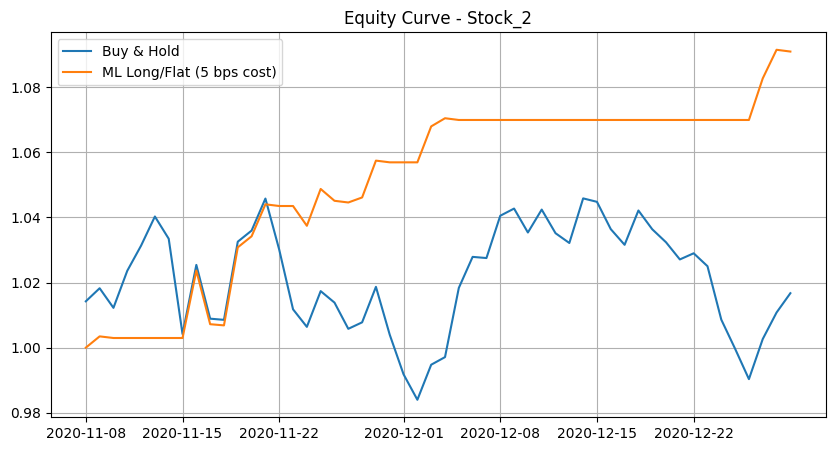

Best stock: Stock_2


,stock,rows_total,rows_test,ridge_alpha,logreg_C,return_mae,return_rmse,return_rmse_baseline0,dir_accuracy,dir_accuracy_baseline,dir_precision,dir_recall,dir_f1,strategy_cumret,strategy_sharpe,strategy_maxdd,baseline_cumret,buyhold_cumret
1,Stock_2,343,52,100.0,0.1,0.008911,0.010865,0.010881,0.673077,0.538462,0.750000,0.480000,0.585366,0.090962,4.535155,-0.016461,0.007361,0.016723
4,Stock_5,343,52,100.0,10.0,0.008791,0.010735,0.010123,0.557692,0.500000,0.500000,0.826087,0.622951,-0.020834,-0.754448,-0.073686,-0.081918,-0.079946
0,Stock_1,343,52,0.1,1.0,0.007257,0.009479,0.009228,0.596154,0.576923,0.450000,0.473684,0.461538,-0.049701,-2.391212,-0.062444,-0.046580,-0.099380
2,Stock_3,343,52,100.0,10.0,0.007359,0.009491,0.009303,0.480769,0.576923,0.464286,0.520000,0.490566,-0.054037,-2.629998,-0.083901,-0.004712,-0.048735
3,Stock_4,343,52,100.0,0.1,0.009578,0.011765,0.011492,0.403846,0.634615,0.432432,0.615385,0.507937,-0.105131,-3.530458,-0.105131,-0.005072,-0.091265


In [7]:
# Plot equity curve for the best stock by Sharpe (if any)
if len(results_df):
    best_stock = results_df.iloc[0]["stock"]
    bt = artifacts_by_stock[best_stock]["bt"]

    plt.figure(figsize=(10, 5))
    plt.plot(bt["buy_hold_equity"], label="Buy & Hold")
    plt.plot(bt["equity"], label="ML Long/Flat (5 bps cost)")
    plt.title(f"Equity Curve - {best_stock}")
    plt.legend()
    plt.grid(True)
    plt.show()

    print("Best stock:", best_stock)
    display(results_df.head(10))
else:
    print("No stocks were successfully processed.")